# Fitting and evaluation of random forest and XGBoost model

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xgb
from yellowbrick.regressor import ResidualsPlot
import os

# set working directory up a level from this file
os.chdir('..')

# Connect to database:
con = sqlite3.connect("NYC-Taxi.db")

## Read in data from sqLite db

In [2]:
cur = con.cursor()
cur.execute('SELECT name from sqlite_master where type= "table"')
cur.fetchall()

[('yellow_cabs',),
 ('green_cabs',),
 ('train_yellow_green',),
 ('test_yellow_green',)]

In [3]:
train_df = pd.read_sql(f"SELECT * FROM train_yellow_green", con)

In [35]:
train_df.columns

Index(['index', 'VendorID', 'pickup_datetime', 'dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'congestion_surcharge', 'Source_file', 'cab', 'Borough',
       'Zone', 'trip_time', 'avg_speed', 'day', 'date', 'holiday_Christmas',
       'holiday_Columbus_Day', 'holiday_Dr._Martin_Luther_King_Jr.',
       'holiday_July_4th', 'holiday_Labor_Day', 'holiday_MemorialDay',
       'holiday_New_Years_Day', 'holiday_Presidents_Day',
       'holiday_Thanksgiving', 'holiday_Veterans_Day', 'holiday_nan',
       'holiday_NYE', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'h

## EDA

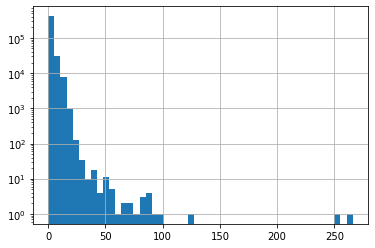

In [33]:
train_df['tip_amount'].hist(log=True, bins=50)

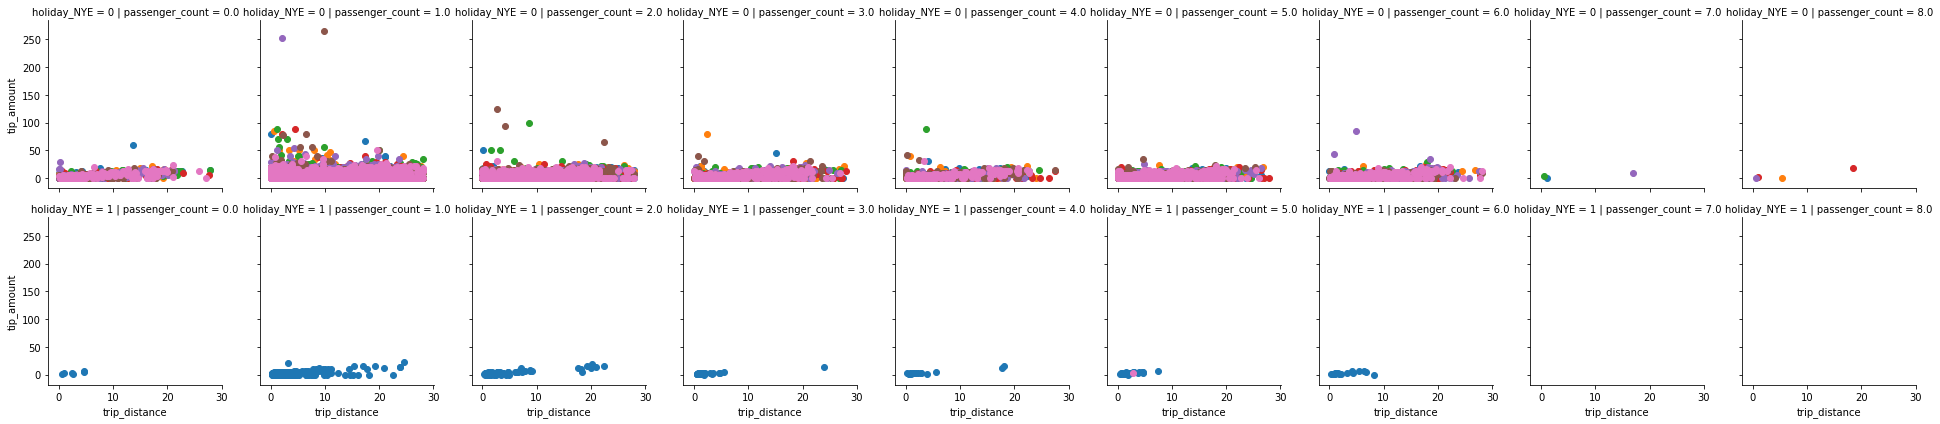

In [6]:
# set facets
facet = sns.FacetGrid(train_df, col="passenger_count", row='holiday_NYE', hue='day')

# Map the scatter plot
facet.map(plt.scatter, 'trip_distance', 'tip_amount')
plt.show()

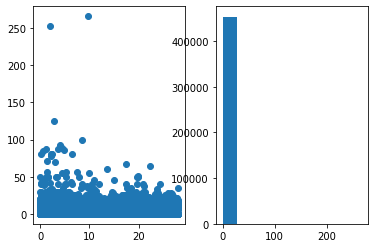

In [7]:
# Create a figure with scatter plot and histogram
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(train_df['trip_distance'], train_df['tip_amount'])
ax2.hist(train_df['tip_amount'])
plt.show()

In [17]:
# fare amount and tip amount by borough, passenger count
train_df.groupby(['Borough', 'passenger_count'])['fare_amount', 'tip_amount'].agg(['mean', 'std'])

/home/joemarlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


fare_amount            tip_amount          
                                     mean        std       mean       std
Borough       passenger_count                                            
Bronx         0.0               19.785714  15.117125   1.628571  3.082314
              1.0               20.992244  15.437350   0.476124  1.886395
              2.0               22.556846  16.386907   0.477861  1.689992
              3.0               20.599415  16.313078   0.561930  1.679201
              4.0               24.050847  14.991002   0.744407  1.904070
              5.0               18.362144  14.416222   0.596127  1.845636
              6.0               22.335443  14.972351   0.784937  1.983361
Brooklyn      0.0               18.175325  12.032953   1.720693  2.747257
              1.0               16.059823  12.086857   1.879205  2.285855
              2.0               17.000967  13.074205   2.120114  3.365038
              3.0               18.328288  14.189087   2.054384  3.202189
              4.0               17.235294  13.360124   2.908361  4.275470
              5.0               15.259978  11.506612   2.171065  2.394839
              6.0               17.067178  12.435764   1.614860  2.364218
              8.0               80.000000        NaN   0.000000       NaN
EWR           1.0               71.750000   3.889087  16.550000  0.707107
              2.0               90.000000        NaN   4.510000       NaN
              5.0               63.500000        NaN  15.760000       NaN
Manhattan     0.0               11.399948   8.340110   2.619422  1.894675
              1.0               11.708811   8.502505   2.599675  2.147786
              2.0               11.847856   8.694653   2.727414  2.144432
              3.0               11.987621   8.917514   2.774427  2.140781
              4.0               11.773593   8.627901   2.727874  2.384126
              5.0               11.745817   8.432224   2.754373  2.032483
              6.0               11.537298   8.292916   2.705284  2.287592
              7.0               49.333333  36.665151   4.400000  5.106858
              8.0               90.000000        NaN  18.560000       NaN
Queens        0.0               38.547915  14.765484   8.107102  5.323046
              1.0               19.990432  15.890037   3.288725  3.940810
              2.0               25.415396  17.752529   4.709455  4.459638
              3.0               29.159950  18.100219   5.741137  5.171837
              4.0               28.638848  18.460708   5.754760  4.871083
              5.0               19.744271  15.981689   3.824530  3.926744
              6.0               23.569972  17.218244   4.469476  4.533204
              8.0                8.000000   0.000000   1.200000  1.697056
Staten Island 1.0               41.486711  21.043338   0.745658  2.025877
              2.0               64.625000  21.669391   0.000000  0.000000
              3.0               55.400000  25.885217   0.000000  0.000000
              4.0               59.083333   5.361126   0.000000  0.000000
              5.0               41.333333  34.059996   0.980000  1.697410
Unknown       0.0               14.008929  10.693877   3.193393  4.181317
              1.0               15.829255  15.879403   3.050503  3.790391
              2.0               17.639266  17.803767   3.315657  3.430428
              3.0               16.257732  14.440091   3.114124  3.104446
              4.0               17.846154  15.184460   3.685641  3.540037
              5.0               13.722222  11.849030   3.082111  2.827517
              6.0               13.363636  10.726918   3.611515  3.098887

## Prep the data

### Fill NAs, NaNs

In [18]:
# drop any rows that are nan or infinite
train_df = train_df[~train_df.isin([np.nan, np.inf, -np.inf]).any(1)]

### Select the training columns

I'm excluding "zone" because it severly slows down the model

In [38]:
# retain only neccessary variables
cols = ['tip_amount', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',  'cab', 'Borough',
        'trip_time', 'avg_speed', 'day', 'holiday_Christmas',
       'holiday_Columbus_Day', 'holiday_Dr._Martin_Luther_King_Jr.',
       'holiday_July_4th', 'holiday_Labor_Day', 'holiday_MemorialDay',
       'holiday_New_Years_Day', 'holiday_Presidents_Day',
       'holiday_Thanksgiving', 'holiday_Veterans_Day', 'holiday_nan',
       'holiday_NYE', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
X_train = train_df.loc[:, cols]
del cols

# dummy code
cols_to_dummy = ['cab', 'Borough', 'Zone', 'day']
cols_to_dummy = ['cab', 'Borough', 'day']
X_train = pd.get_dummies(X_train, columns=cols_to_dummy)
del cols_to_dummy

In [39]:
pd.set_option('display.max_columns', None)
X_train.head()

,tip_amount,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,avg_speed,holiday_Christmas,holiday_Columbus_Day,holiday_Dr._Martin_Luther_King_Jr.,holiday_July_4th,holiday_Labor_Day,holiday_MemorialDay,holiday_New_Years_Day,holiday_Presidents_Day,holiday_Thanksgiving,holiday_Veterans_Day,holiday_nan,holiday_NYE,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,cab_green,cab_yellow,Borough_Bronx,Borough_Brooklyn,Borough_EWR,Borough_Manhattan,Borough_Queens,Borough_Staten Island,Borough_Unknown,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0.70,2.0,2.43,12.0,0.0,0.5,0.0,0.3,2.50,14.0,10.414286,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0.00,2.0,4.90,16.5,0.5,0.5,0.0,0.3,0.00,13.0,22.615385,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,2.16,1.0,1.34,10.0,0.0,0.5,0.0,0.3,0.00,15.0,5.360000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,1.50,1.0,1.02,6.5,0.0,0.5,0.0,0.3,0.00,6.0,10.200000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3.21,1.0,2.38,12.5,0.0,0.5,0.0,0.3,2.75,15.0,9.520000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [40]:
# check for NaNs
np.all(np.isfinite(X_train))

True

## Split the data into train and test

In [43]:
# split the data
X = X_train.drop('tip_amount', axis=1)
y = X_train.loc[:, 'tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Random Forest

In [49]:
# Instantiate rf
rf = RandomForestRegressor(n_estimators=50,
                           random_state=44)
            
# Fit rf to the training set    
rf.fit(X_train, y_train) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=44, verbose=0, warm_start=False)

In [51]:
# Predict the tips
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 1.68


In [52]:
rmse_test / np.mean(y_test)

0.6456178298507289

## Examine the feature importances

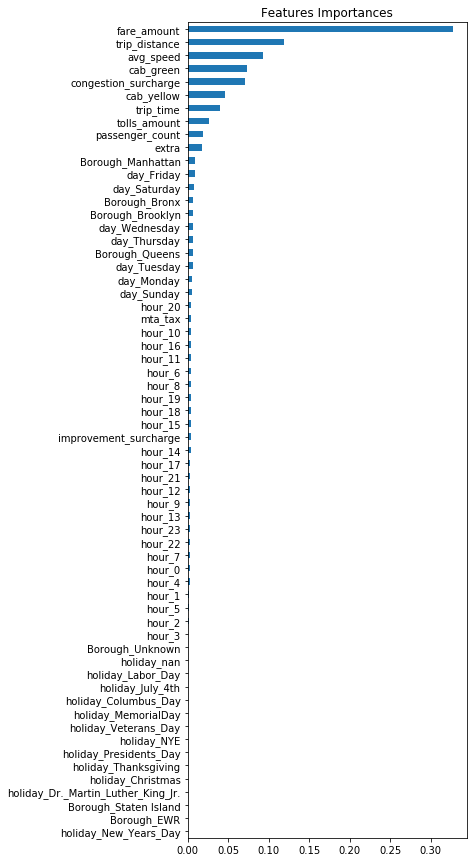

In [66]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh')
plt.title('Features Importances')
plt.gcf().set_size_inches(5, 15)
plt.show()

/home/joemarlo/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


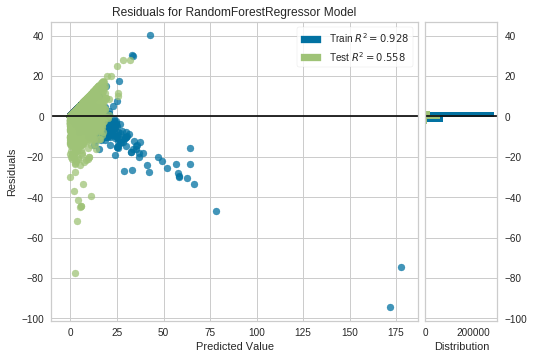

In [67]:
# resiludals plot
visualizer = ResidualsPlot(rf)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


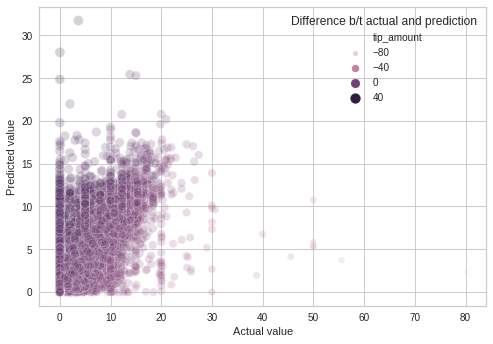

In [68]:
# residuals plot
ax = sns.scatterplot(x=y_test, y=y_pred, hue=y_pred-y_test, size=y_pred-y_test, alpha=0.2)
ax.set(xlabel='Actual value', ylabel='Predicted value')
ax.legend(title="Difference b/t actual and prediction")
plt.show()

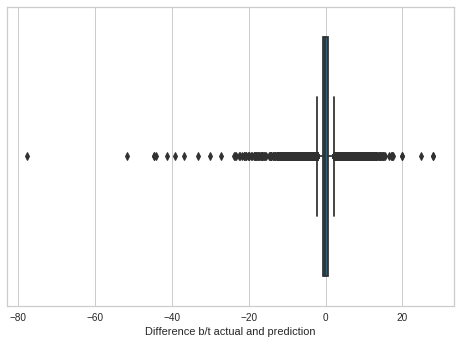

In [69]:
# boxplot of residuals
ax = sns.boxplot(x=y_pred-y_test)
ax.set(xlabel='Difference b/t actual and prediction')
plt.show()

## XGBoost

In [75]:
# Instantiate the XGBRegressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=44, max_depth=10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

In [76]:
# Compute the rmse
MSE(y_test, preds)**(1/2)

1.6374321488029564

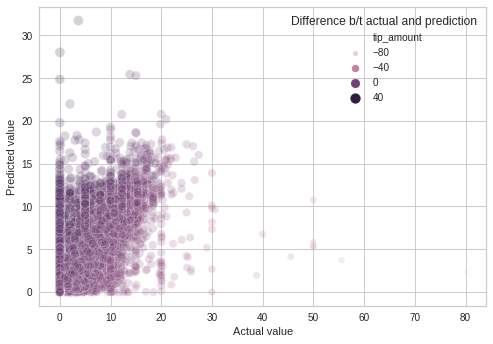

In [77]:
# residuals plot
ax = sns.scatterplot(x=y_test, y=y_pred, hue=y_pred-y_test, size=y_pred-y_test, alpha=0.2)
ax.set(xlabel='Actual value', ylabel='Predicted value')
ax.legend(title="Difference b/t actual and prediction")
plt.show()

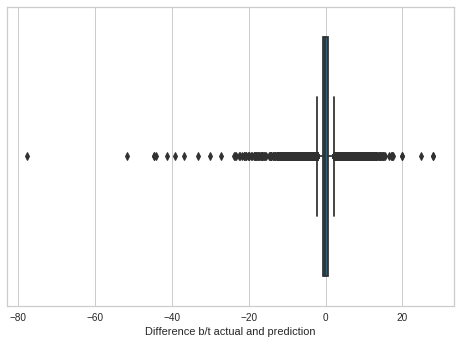

In [78]:
# boxplot of residuals
ax = sns.boxplot(x=y_pred-y_test)
ax.set(xlabel='Difference b/t actual and prediction')
plt.show()

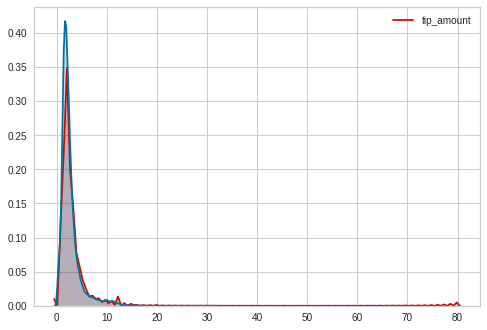

In [86]:
# density plots of actual and prediction
p1 = sns.kdeplot(y_test, shade=True, color="r")
p1 = sns.kdeplot(y_pred, shade=True, color="b")
plt.show()

### Cross validate

In [79]:
# Create the DMatrix: housing_dmatrix
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":6}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         2.663094        0.025302        2.665107       0.079056
1         2.257208        0.026657        2.263662       0.087431
2         2.022459        0.028395        2.033040       0.094099
3         1.891739        0.030124        1.906137       0.096876
4         1.819620        0.029064        1.838642       0.098780


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.630171 to fit


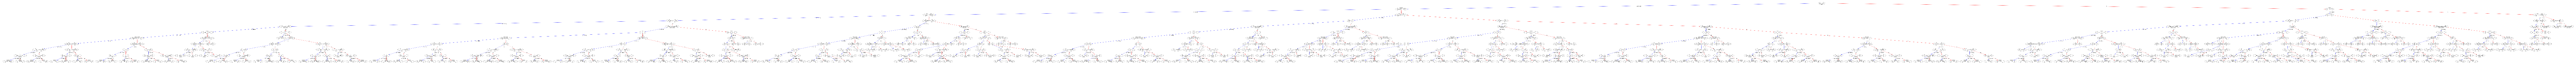

In [81]:
# plot the last tree
xgb.plot_tree(xg_reg, num_trees=99)
plt.gcf().set_size_inches(150, 250)
plt.show()

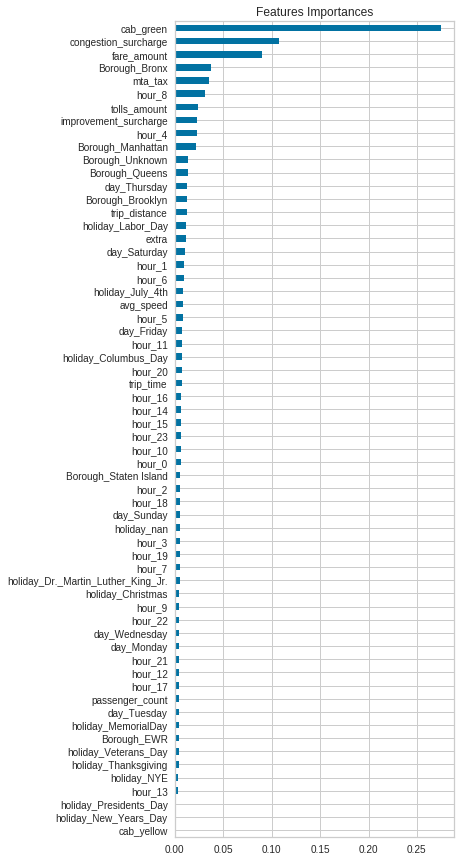

In [84]:
# Create a pd.Series of features importances
importances = pd.Series(data=xg_reg.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh')
plt.title('Features Importances')
plt.gcf().set_size_inches(5, 15)
plt.show()

## Simple regression

In [95]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_test, y_test)
y_pred = reg.predict(X_test)
MSE(y_test, y_pred)**(1/2)

1.8532747995598653